Celem projektu jest opracowanie modelu predykcyjnego Long-Short Term Memory (LSTM), który oszacuje za pomocą regresji liniowej wartość kursu BTCUSD na podstawie wprowadzonych danych wejściowych z innych instrumentów.

Następnie, model zostanie porównany z predykcją średniej kroczącej, a także zmodyfikowany do działania wyłącznie na podstawie kursu BTCUSD. Metryki wykorzystane do oceny jakości to Mean Squared Error (MSE) oraz Mean Absolute Error (MAE).

Ostatnim etapem projektu jest wprowadzenie elementu generalizacji za pomocą innych danych uczących. Nowymi danymi wejściowymi i wyjściowymi będzie kurs NASDAQ.

# Load data

In [1]:
import pandas as pd
from siml_data import Featureset

In [2]:
feature_loader = Featureset()

In [3]:
df = feature_loader.get()

## Check for NaN values & verify value types

In [4]:
df.isna().sum().sum()

0

In [5]:
df.dtypes

GCM24Open        float64
GCM24High        float64
GCM24Low         float64
GCM24Close       float64
IXICOpen         float64
IXICHigh         float64
IXICLow          float64
IXICClose        float64
HKDOpen          float64
HKDHigh          float64
HKDLow           float64
HKDClose         float64
GXCOpen          float64
GXCHigh          float64
GXCLow           float64
GXCClose         float64
CNYOpen          float64
CNYHigh          float64
CNYLow           float64
CNYClose         float64
GSPCOpen         float64
GSPCHigh         float64
GSPCLow          float64
GSPCClose        float64
CLK24Open        float64
CLK24High        float64
CLK24Low         float64
CLK24Close       float64
MCHIOpen         float64
MCHIHigh         float64
MCHILow          float64
MCHIClose        float64
0386Open         float64
0386High         float64
0386Low          float64
0386Close        float64
BLKOpen          float64
BLKHigh          float64
BLKLow           float64
BLKClose         float64


## Remove all channels except Close price

In [6]:
[x for x in df.columns if 'btc' in x.lower()]

['btcusd_dOpen', 'btcusd_dHigh', 'btcusd_dLow', 'btcusd_dClose']

In [7]:
df = df.drop(columns=[c for c in df.columns if 'Close' not in c])

## Check correlation

<Axes: >

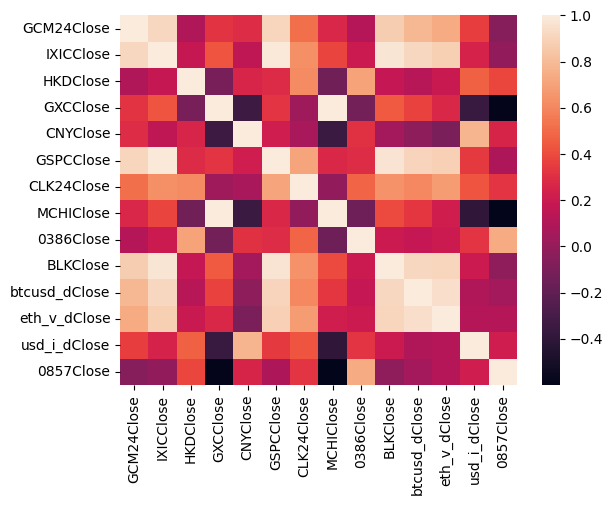

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(df.corr())

In [9]:
df.corr()['btcusd_dClose'].abs().sort_values(ascending=False).head(10)

btcusd_dClose    1.000000
eth_v_dClose     0.945606
IXICClose        0.916503
BLKClose         0.912576
GSPCClose        0.902721
GCM24Close       0.786737
CLK24Close       0.605982
GXCClose         0.372193
MCHIClose        0.327378
0386Close        0.173504
Name: btcusd_dClose, dtype: float64

# Select features

In [29]:
from sklearn.linear_model import LinearRegression

In [39]:
regressor = LinearRegression()
regressor.fit(df.drop(columns=['btcusd_dClose']).values, df['btcusd_dClose'].values)

LinearRegression()

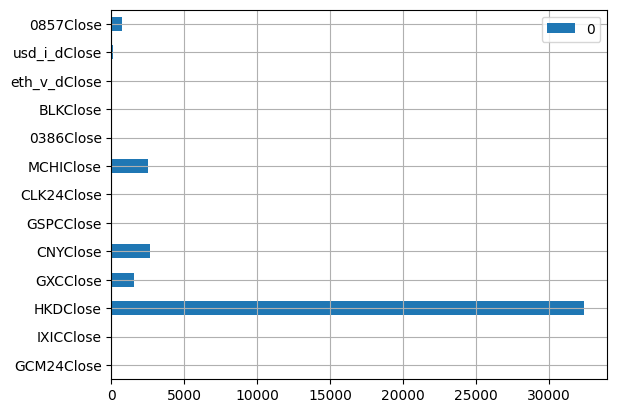

In [55]:
feature_relevance = pd.DataFrame({k:[v] for k,v in zip(df.drop(columns=['btcusd_dClose']).columns, regressor.coef_)}).T.abs()
feature_relevance.plot(kind='barh')
plt.grid()

In [56]:
feature_relevance.describe()

,0
count,13.000000
mean,3080.839079
std,8868.138042
min,0.879600
25%,8.479250
50%,33.519536
75%,1528.619600
max,32414.603184


In [65]:
threshold = 8.5
best_features = feature_relevance > threshold
selected_features = best_features[best_features.values].index.tolist()
selected_features

['HKDClose',
 'GXCClose',
 'CNYClose',
 'MCHIClose',
 '0386Close',
 'BLKClose',
 'eth_v_dClose',
 'usd_i_dClose',
 '0857Close']

## Preprocess data

In [66]:
from siml_pipeline import Pipeline

In [67]:
p = Pipeline()
X_train, X_test, Y_train, Y_test = p.process(df[selected_features + ['btcusd_dClose']], 'btcusd_dClose')

In [68]:
n_of_features = X_train.shape[-1]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1240, 10, 9), (407, 10, 9), (1240, 1), (407, 1))

# Train model

In [69]:
from siml_model import build_model

In [77]:
model = build_model(p.num_days, n_of_features)

The number of model trainable parameters should have at most the same order of magnitude as the training data samples.

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 24)            3264      
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 24)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 12)            1776      
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 12)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 6)             456       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 6)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 60)               

In [79]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [80]:
epochs = 10
batch = 32

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch)

Epoch 1/10
39/39 [==============================] - 4s 34ms/step - loss: 0.8907 - mae: 0.6187 - val_loss: 2.5335 - val_mae: 1.4207
Epoch 2/10
39/39 [==============================] - 1s 18ms/step - loss: 0.3744 - mae: 0.3671 - val_loss: 1.7117 - val_mae: 1.2080
Epoch 3/10
39/39 [==============================] - 1s 22ms/step - loss: 0.1513 - mae: 0.2376 - val_loss: 1.4810 - val_mae: 1.1197
Epoch 4/10
39/39 [==============================] - 1s 22ms/step - loss: 0.1345 - mae: 0.2160 - val_loss: 1.0504 - val_mae: 0.9325
Epoch 5/10
39/39 [==============================] - 1s 25ms/step - loss: 0.1356 - mae: 0.2154 - val_loss: 1.0878 - val_mae: 0.9506
Epoch 6/10
39/39 [==============================] - 1s 30ms/step - loss: 0.1206 - mae: 0.2043 - val_loss: 0.9801 - val_mae: 0.9001
Epoch 7/10
39/39 [==============================] - 1s 25ms/step - loss: 0.1061 - mae: 0.1925 - val_loss: 1.0064 - val_mae: 0.9094
Epoch 8/10
39/39 [==============================] - 1s 30ms/step - loss: 0.1013 - m

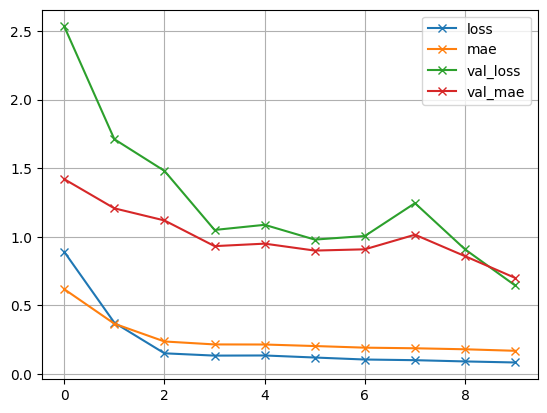

In [81]:
for k,v in history.history.items():
    plt.plot(v, 'x-', label=k)
plt.legend()
plt.grid()

# Single feature model

In [19]:
from siml_pipeline import SingleFeaturePipeline
ONE_FEATURE = 1

In [20]:
sp = SingleFeaturePipeline()
X_train, X_test, Y_train, Y_test = sp.process(df['btcusd_dClose'])

In [22]:
model = build_model(sp.num_days, ONE_FEATURE, output_size=sp.look_ahead)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 24)            2496      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 24)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 12)            1776      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 12)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 6)             456       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 6)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)               

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [25]:
epochs = 10
batch = 32

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch)

Epoch 1/10
40/40 [==============================] - 4s 33ms/step - loss: 0.9430 - mae: 0.8093 - val_loss: 1.1499 - val_mae: 0.8320
Epoch 2/10
40/40 [==============================] - 1s 21ms/step - loss: 0.6853 - mae: 0.5504 - val_loss: 0.8987 - val_mae: 0.6825
Epoch 3/10
40/40 [==============================] - 1s 22ms/step - loss: 0.4645 - mae: 0.4014 - val_loss: 0.5820 - val_mae: 0.4764
Epoch 4/10
40/40 [==============================] - 1s 23ms/step - loss: 0.3251 - mae: 0.3134 - val_loss: 0.4612 - val_mae: 0.4276
Epoch 5/10
40/40 [==============================] - 1s 20ms/step - loss: 0.2377 - mae: 0.2606 - val_loss: 0.3534 - val_mae: 0.3872
Epoch 6/10
40/40 [==============================] - 1s 23ms/step - loss: 0.1837 - mae: 0.2306 - val_loss: 0.3066 - val_mae: 0.3828
Epoch 7/10
40/40 [==============================] - 1s 24ms/step - loss: 0.1446 - mae: 0.2128 - val_loss: 0.2646 - val_mae: 0.3809
Epoch 8/10
40/40 [==============================] - 1s 26ms/step - loss: 0.1150 - m

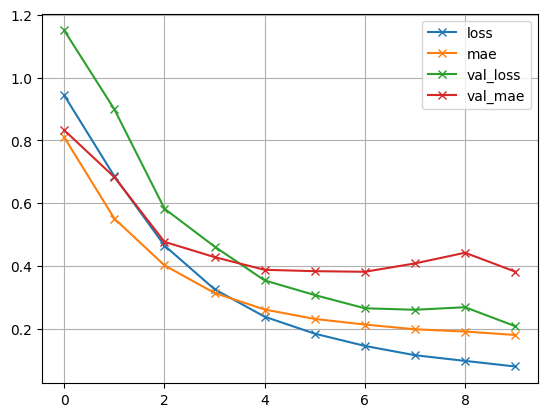

In [28]:
for k,v in history.history.items():
    plt.plot(v, 'x-', label=k)
plt.legend()
plt.grid()

# Testing

In [26]:
MA = df.rolling(window=10).mean().rename(columns=lambda n: n.replace('Close', 'MA'))
btc = pd.concat([df['btcusd_dClose'], MA['btcusd_dMA']], axis=1)

<Axes: xlabel='Date'>

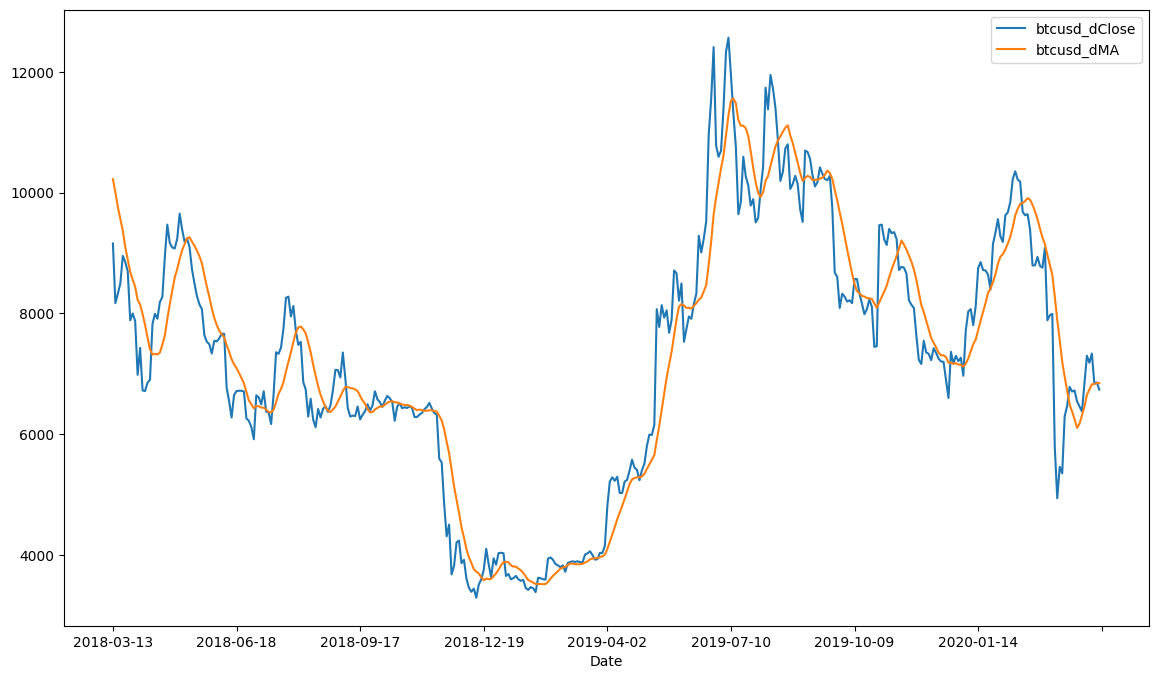

In [27]:
btc.iloc[500:900].plot(figsize=(14,8))

# Grid Search
Optimize model batch size.

# Generalization
Using the same model on different data.